# Running training

Let's run baseline foundation and flood training: 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from postprocessing.roads.wkt_to_G import generate_road_network_graph
from foundation_eval import run_foundation_eval
import os

run_root = '/tmp/share/runs/spacenet8/nenad'

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train

In [ ]:
# !python /tmp/share/repos/nenad/baseline/train_foundation_features.py --train_csv /tmp/share/data/spacenet8/sn8_data_train.csv --val_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_dir /tmp/share/runs/spacenet8/nenad/foundation --model_name resnet34 --lr 0.0001 --batch_size 4 --n_epochs 30 --gpu 0
# !python /tmp/share/repos/nenad/baseline/train_flood.py --train_csv /tmp/share/data/spacenet8/sn8_data_train.csv --val_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_dir /tmp/share/runs/spacenet8/nenad/flood --model_name resnet34_siamese --lr 0.0001 --batch_size 2 --n_epochs 30 --gpu 0

# Evaluation

We run evaluation on validation data to generate tifs and pngs, first for foundation model:

In [10]:
run_folder = '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13'

model_path = os.path.join(run_folder, 'best_model.pth')
in_csv = '/tmp/share/data/spacenet8/sn8_data_val.csv'
save_fig_dir = os.path.join(run_folder, 'pngs')
save_preds_dir = os.path.join(run_folder, 'tiffs')
model_name = 'resnet34'

run_foundation_eval(model_path=model_path, 
                    in_csv=in_csv, 
                    save_fig_dir=None, 
                    save_preds_dir=save_preds_dir, 
                    model_name=model_name)

loaded 122 image filepaths
Saving results to /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/eval_results.csv
Total CPU memory: 30086.79 MB
Available CPU memory: 23177.02 MB
Used CPU memory: 6442.30 MB
Percentage of used CPU memory: 23.0%
evaluating:  0 10500500C4DD7000_0_16_63.tif
Percentage of used CPU memory: 23.1%
Variable: predictions, Size: 216320160 bytes
Variable: gts, Size: 216320160 bytes
Variable: roadspeed_prediction, Size: 108160144 bytes
Variable: road_pred_arr, Size: 13520144 bytes
Variable: building_prediction, Size: 13520128 bytes
evaluating:  1 105001001A0FFC00_0_12_14.tif
Percentage of used CPU memory: 24.8%
Variable: predictions, Size: 216320160 bytes
Variable: gts, Size: 216320160 bytes
Variable: roadspeed_prediction, Size: 108160144 bytes
Variable: road_pred_arr, Size: 13520144 bytes
Variable: building_prediction, Size: 13520128 bytes
evaluating:  2 10400100684A4B00_1_10_82.tif
Percentage of used CPU memory: 25.0%
Variable: pred

Alternative method of running:

In [18]:
# run_folder="/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13"
# model_path = os.path.join(run_folder, "best_model.pth")
# tiffs_path = os.path.join(run_folder, "tiffs")
# !python foundation_eval.py --model_path $model_path --in_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_preds_dir $tiffs_path --gpu 0 --model_name resnet34

and then for flood model:

In [ ]:
# python baseline/flood_eval.py --model_path /tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_07-05-2023-06-26/best_model.pth --in_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_preds_dir /tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_07-05-2023-06-26/tiffs --gpu 0 --model_name resnet34_siamese
# python baseline/flood_eval.py --model_path /tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_07-05-2023-06-26/best_model.pth --in_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_fig_dir /tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_07-05-2023-06-26/pngs --gpu 0 --model_name resnet34_siamese

The tiff images are segmentation masks. For example let's look at some of the created tifs and pngs:

Specifically let's look at `10400100684A4B00_1_6_88` image: 

In [11]:
im = '/tmp/share/data/spacenet8/Louisiana-East_Training_Public/PRE-event/10400100684A4B00_1_6_88.tif'
image = Image.open(im)
image


ValueError: Could not save to PNG for display

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=1300x1300 at 0x7F925C1639D0>

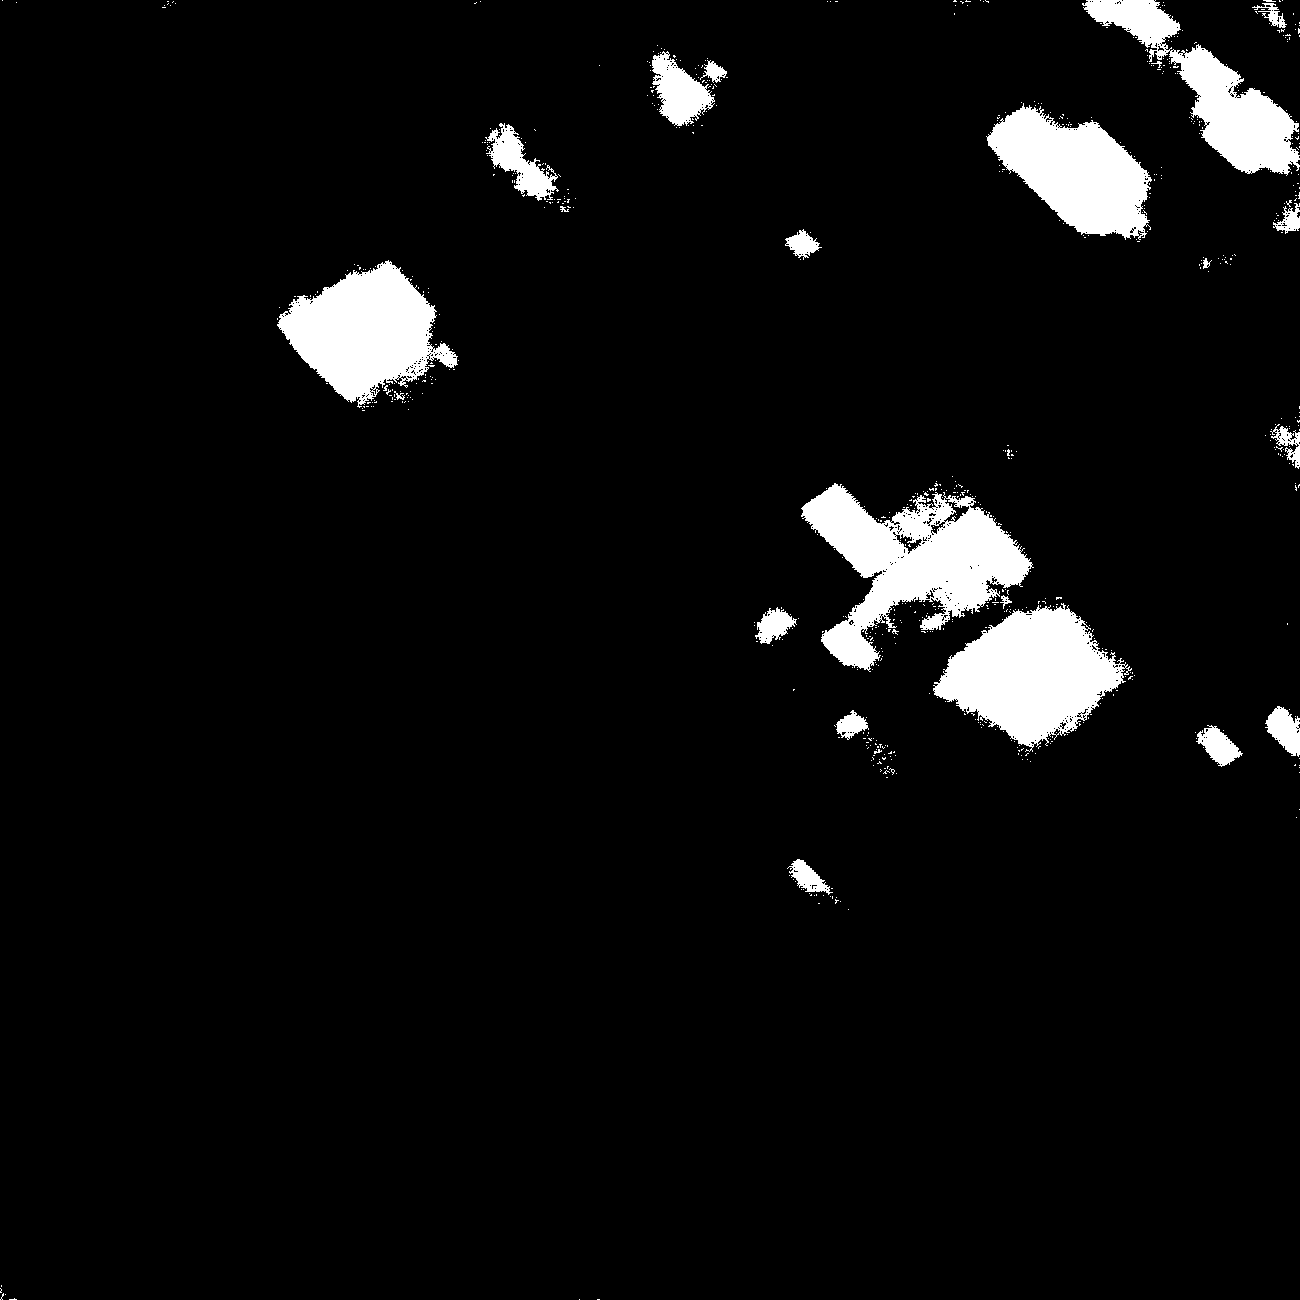

In [8]:
im1 = os.path.join(run_root, 'foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10400100684A4B00_1_6_88_buildingpred.tif')
image = Image.open(im1)
image

Convert to numpy:

In [9]:
image_array = np.array(image)

In [12]:
np.unique(image_array)

array([  0, 255], dtype=uint8)

and this is a binary mask of building vs no building obtained from the pre-flood image only.

PNG image is for visalization, combines buidlings and roads:

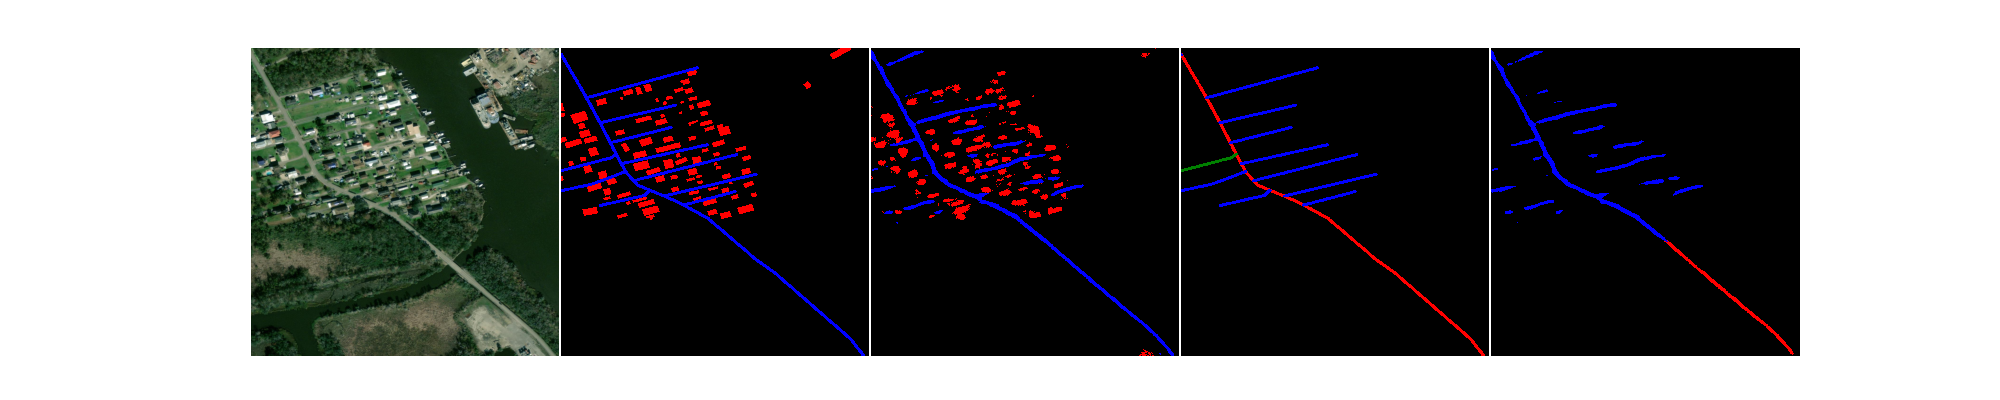

In [16]:
im2 = os.path.join(run_root, 'foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/pngs/10300100AF395C00_2_16_51_pred.png')
image = Image.open(im2)
image


In [ ]:

# Convert the image to a NumPy array
image_array = np.array(image)

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Optional: Remove axis labels
plt.show()

In [ ]:
# share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10400100684A4B00_1_6_88_buildingpred.tif

In [ ]:
# share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/pngs/10300100AF395C00_2_21_43_pred.png

# Postprocessing

## Roads

I'm running into issue with road postprocessing (see below):

In [ ]:
# !python baseline/postprocessing/roads/vectorize_roads.py --im_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs --out_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds --write_shps --write_graphs --write_csvs --write_skeletons

number of prediction images to vectorize:  107
output shapefile dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_shps
output graph dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_graphs
output csv dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_csvs
output skeleton dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/skeletons
Executing make_skeleton...
1300
1300
(1300, 1300)
1690000
Run preprocess() with skimage
Time to run preprocess(): 0.05678963661193848 seconds
skeletonize...
Time to run skimage.skeletonize(): 0.04388785362243652 seconds
ske.shape: (1300, 1300)
Time to run make_skeleton: 0.17720818519592285 seconds
Execute sknw...
35 random node props: {'pts': array([[1152, 1295]], dtype=int16), 'o': array([1152., 1295.])}
Clean out small terminals - round 0
Clean

In [3]:
cd /tmp/share/repos/nenad/baseline


/tmp/share/repos/nenad/baseline


In [20]:
from postprocessing.roads.utils import make_logger, rdp

The following is not running properly:

In [26]:
root = '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds'
generate_road_network_graph(wkt_submission=os.path.join(root, 'sknw_wkt.csv'),
                            graph_dir=os.path.join(root, 'graphs_nospeed'),
                            log_file=os.path.join(root, 'wkt_to_G.log'),
                            min_subgraph_length_pix=20,
                            min_spur_length_m=10)


log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv
log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv
log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv


['/tmp/share/repos/nenad/baseline', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/torchtext-0.12.0a0-py3.8-linux-x86_64.egg']
image_ids: ['/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_13_45_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_15_44_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_15_49_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_16_44_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_16_51_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ValueError: Geometry must be unprojected to calculate UTM zone

no point in attempting the next step:

In [ ]:
# !python infer_speed.py --eval_csv /tmp/share/runs/spacenet8/nenad/sn8_data_val.csv --mask_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/road_preds --graph_dir $GRAPH_NO_SPEED_DIR --graph_speed_dir $GRAPH_SPEED_DIR --log_file $INFER_SPEED_LOG_FILE

## Buildings

The building postoprocessing is done as follows in one line: 

In [9]:
# !python baseline/postprocessing/buildings/building_postprocessing.py --foundation_pred_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs --flood_pred_dir /tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_11-05-2023-10-48/tiffs --out_submission_csv /tmp/share/runs/spacenet8/nenad/building_preds/building_submission.csv --out_shapefile_dir /tmp/share/runs/spacenet8/nenad/building_preds/pred_shps --square_size 5 --simplify_tolerance 0.75 --min_area 5 --percent_positive 0.5

To see what's happening, lets call underling python method `main_w_flood` (I have to manually create `building_preds/pred_shps` folder):

In [10]:
from postprocessing.buildings.building_postprocessing import main_w_flood

In [12]:
root_dir = os.path.join(run_root, 'foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs')
flood_dir = os.path.join(run_root, 'flood/resnet34_siamese_lr1.00e-04_bs2_11-05-2023-10-48/tiffs')
out_submission_csv = os.path.join(run_root, 'building_preds/building_submission.csv')
out_shapefile_dir = os.path.join(run_root, 'building_preds/pred_shps')

square_size = 5 
simplify_tolerance = 0.75
min_area = 5
percent_positive = 0.5

main_w_flood(root_dir,
             flood_dir,
             out_submission_csv,
             out_shapefile_dir,
             square_size,
             min_area,
             simplify_tolerance,
             percent_positive)

postprocessing 107 tiles


note that:
- building segmentation mask has 1 or 0 for building
- flood segmentation mask has: 0 for background, 1 non-flooded building, 2 is flooded building, 3 is non-flooded road, 4 is flooded road
- morphological opening is done on a building segmentation image, not flood image,
- to determine if the building was flooded an overlap of flood segmentation mask and building segmentation mask is done, with overlap of perc_positive (i.e. means "any blob with number of flood pixels above this percentage, will be classified as fully flooded. otherwise it is not flooded")
- poligonization converts mask to a osgeo.ogr.DataSource (some compact raster format),
- some fancy `remove_small_polygons_and_simplify` simlifies the pologon, it's all using `osgeo` library,
- `save_to_shapefile` saves 5 files (cpg, dbf, prj, shp, shx) per one tiff image.
- every buidling object is then written line by line in a `building_submission.csv` file.

Let's look at the building submissions csv file:

In [6]:
df = pd.read_csv('/tmp/share/runs/spacenet8/nenad/building_preds/building_submission.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
df.tail()

,ImageId,Object,Flooded,Wkt_Pix,Wkt_Geo
2001,105001001A0FFC00_0_13_3,Building,False,"POLYGON ((79 1170, 79 1175, 71 1175, 71 1177, 66 1178, 66 1182, 60 1182, 60 1189, 69 1189, 69 1193, 72 1197, 75 1202, 82 1202, 88 1198, 95 1198, 95 1195, 101 1195, 101 1192, 104 1192, 102 1182, 100 1181, 101 1175, 95 1175, 94 1172, 88 1170, 79 1170))","POLYGON ((-90.0037644604752 29.731987285385,-90.003769064341 29.7319688699216,-90.0038058952676 29.7319688699216,-90.0038058952676 29.7319550583242,-90.003824310731 29.7319550583241,-90.0038289145968 29.7319366428608,-90.003851933926 29.7319366428608,-90.003851933926 29.7319044158,-90.0038151029993 29.7318998119342,-90.0038151029993 29.7318813964709,-90.003796687536 29.7318675848733,-90.0037874798043 29.7318399616784,-90.0037552527435 29.7318399616784,-90.0037276295485 29.7318629810075,-90.0036954024877 29.7318583771417,-90.0036907986219 29.7318721887392,-90.0036631754269 29.731876792605,-90.0036631754269 29.7318906042025,-90.0036539676952 29.7318906042025,-90.0036585715611 29.7319366428608,-90.0036723831585 29.7319412467266,-90.0036677792927 29.7319688699216,-90.0036907986219 29.7319688699216,-90.0037000063535 29.7319826815191,-90.0037230256827 29.731987285385,-90.0037644604752 29.731987285385))"
2002,105001001A0FFC00_0_13_3,Building,False,"POLYGON ((195 1240, 190 1246, 190 1250, 192 1251, 188 1252, 188 1257, 192 1259, 192 1266, 210 1268, 216 1265, 217 1256, 214 1247, 210 1243, 201 1243, 201 1240, 195 1240))","POLYGON ((-90.0032304120388 29.7316650147768,-90.0032580352337 29.7316419954476,-90.0032580352337 29.7316189761185,-90.0032442236363 29.7316143722527,-90.0032626390996 29.7316143722526,-90.0032626390996 29.7315867490577,-90.0032442236363 29.731577541326,-90.0032442236363 29.7315453142652,-90.0031659579171 29.7315407103993,-90.0031383347221 29.7315545219968,-90.0031291269905 29.7315913529235,-90.003142938588 29.731632787716,-90.0031613540513 29.7316512031793,-90.0032073927096 29.7316512031793,-90.0032073927096 29.7316650147768,-90.0032304120388 29.7316650147768))"
2003,10300100AF395C00_2_29_35,Building,<NA>,POLYGON EMPTY,POLYGON EMPTY
2004,105001001A0FFC00_0_17_8,Building,<NA>,POLYGON EMPTY,POLYGON EMPTY
2005,10300100AF395C00_2_20_37,Building,<NA>,POLYGON EMPTY,POLYGON EMPTY


Each row is one building with Wkt_Geo coordiantes. Let's look at some flooded buildings:


In [7]:
df_flooded = df[df['Flooded'] == True]
df_flooded.head()

,ImageId,Object,Flooded,Wkt_Pix,Wkt_Geo
57,105001001A0FFC00_0_12_5,Building,True,"POLYGON ((470 115, 466 118, 466 124, 464 124, 463 135, 456 135, 456 144, 470 144, 472 148, 482 148, 485 144, 496 141, 496 132, 486 131, 483 127, 481 127, 481 118, 470 115))","POLYGON ((-90.0079539783815 29.7248743126759,-90.007967789979 29.7248605010784,-90.007967789979 29.7248374817492,-90.0079769977107 29.7248374817492,-90.0079862054423 29.7247868392251,-90.0080138286373 29.7247822353593,-90.0080138286373 29.7247454044326,-90.0079493745157 29.7247454044326,-90.0079447706498 29.7247223851035,-90.0078941281257 29.7247223851035,-90.007884920394 29.7247408005668,-90.0078296740041 29.7247592160301,-90.0078296740041 29.7247960469568,-90.0078757126624 29.7248052546884,-90.0078895242599 29.7248236701517,-90.0079033358573 29.7248236701517,-90.0079033358573 29.7248651049442,-90.0079539783815 29.7248743126759))"
104,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((850 83, 850 84, 837 87, 834 90, 834 100, 848 99, 848 96, 850 99, 858 99, 858 96, 864 97, 867 94, 867 83, 850 83))","POLYGON ((-89.9882448287585 29.7010861379265,-89.9882448287585 29.7010769301949,-89.9883046790143 29.7010677224632,-89.9883230944776 29.7010539108657,-89.9883230944776 29.7010078722074,-89.9882540364902 29.7010124760732,-89.9882540364902 29.7010216838049,-89.9882448287585 29.7010124760732,-89.9882079978319 29.7010124760732,-89.9882079978319 29.7010216838049,-89.9881803746369 29.7010170799391,-89.9881665630394 29.7010308915366,-89.9881665630394 29.7010861379265,-89.9882448287585 29.7010861379265))"
107,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((1281 343, 1269 350, 1272 364, 1277 364, 1279 373, 1296 376, 1297 370, 1300 370, 1300 350, 1298 347, 1287 345, 1287 343, 1281 343))","POLYGON ((-89.9862651664511 29.6998891328104,-89.9863158089753 29.6998523018838,-89.9863019973778 29.6997878477622,-89.9862835819144 29.6997878477622,-89.986269770317 29.6997464129697,-89.9861961084636 29.6997326013722,-89.9861915045978 29.699764828433,-89.9861776930003 29.699764828433,-89.9861776930003 29.6998569057496,-89.9861822968662 29.6998661134813,-89.9862329393903 29.699875321213,-89.9862375432561 29.6998891328104,-89.9862651664511 29.6998891328104))"
108,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((885 444, 885 449, 892 448, 892 444, 885 444))","POLYGON ((-89.9880882973202 29.6994241423615,-89.9880882973202 29.6994011230323,-89.9880560702594 29.6994011230324,-89.9880560702594 29.6994241423615,-89.9880882973202 29.6994241423615))"
223,105001001A0FFC00_0_17_15,Building,True,"POLYGON ((465 267, 456 267, 456 271, 446 274, 445 280, 447 280, 445 280, 445 286, 446 285, 446 290, 449 290, 452 296, 455 296, 456 300, 468 300, 468 302, 474 302, 478 290, 481 290, 484 277, 481 274, 474 276, 472 267, 465 267))","POLYGON ((-89.9780518698084 29.6643288731309,-89.9780887007351 29.6643242692651,-89.9780887007351 29.6643104576676,-89.9781393432592 29.6642966460701,-89.978143947125 29.6642690228751,-89.9781301355276 29.6642644190093,-89.978143947125 29.6642644190093,-89.978143947125 29.6642413996801,-89.9781347393934 29.6642413996802,-89.9781347393934 29.6642229842168,-89.9781209277959 29.6642229842168,-89.9781117200642 29.664190757156,-89.9780933046009 29.664190757156,-89.9780887007351 29.6641723416927,-89.9780380582109 29.6641769455585,-89.9780380582109 29.6641677378268,-89.9780104350159 29.6641677378268,-89.9779920195526 29.664218380351,-89.9779782079551 29.664218380351,-89.9779643963576 29.6642828344726,-89.9779782079551 29.6642920422043,-89.9780104350159 29.6642874383384,-89.9780150388818 29.6643288731309,-89.9780518698084 29.6643288731309),(-89.9780104350159 29.6642644190093,-89.9780104350159 29.6642598151435,-89.9780058311501 29.6642598151435,-89.9780058311501 29.6642644190093,-89.9780104350159 29.6642644190093))"


There are 428 flooded buildings in the 

In [8]:
len(df_flooded)

428

In [79]:
df_flooded.iloc[0]['Wkt_Geo']

'POLYGON ((-90.0079539783815 29.7248743126759,-90.007967789979 29.7248605010784,-90.007967789979 29.7248374817492,-90.0079769977107 29.7248374817492,-90.0079862054423 29.7247868392251,-90.0080138286373 29.7247822353593,-90.0080138286373 29.7247454044326,-90.0079493745157 29.7247454044326,-90.0079447706498 29.7247223851035,-90.0078941281257 29.7247223851035,-90.007884920394 29.7247408005668,-90.0078296740041 29.7247592160301,-90.0078296740041 29.7247960469568,-90.0078757126624 29.7248052546884,-90.0078895242599 29.7248236701517,-90.0079033358573 29.7248236701517,-90.0079033358573 29.7248651049442,-90.0079539783815 29.7248743126759))'

Let's load reference csv files:

In [80]:
ref1 = pd.read_csv('/tmp/share/data/spacenet8/Germany_Training_Public/Germany_Training_Public_reference.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
ref2 = pd.read_csv('/tmp/share/data/spacenet8/Louisiana-East_Training_Public/Louisiana-East_Training_Public_reference.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
ref = pd.concat([ref1, ref2])
ref.head()

,ImageId,Object,Wkt_Pix,Flooded,length_m,travel_time_s
0,10500500C4DD7000_0_44_69,Road,LINESTRING EMPTY,<NA>,NaN,NaN
1,10500500C4DD7000_0_37_69,Road,"LINESTRING (1300.0000000000637 125.11088048440429, 1264.8329929537006 119.92324021553506)",False,9.594786,0.715431
2,10500500C4DD7000_0_37_69,Road,"LINESTRING (1264.8329929537006 119.92324021553506, 1170.2292368980147 103.03829985213261)",False,26.113182,1.947117
3,10500500C4DD7000_0_37_69,Road,"LINESTRING (1170.2292368980147 103.03829985213261, 1153.0236964009407 101.67574928408781)",False,4.608716,0.343647
4,10500500C4DD7000_0_37_69,Road,"LINESTRING (1153.0236964009407 101.67574928408781, 1042.6838171267377 67.02421819128786)",False,32.691009,2.437590


We now need to compare building predicitons csv file with the reference csv files in a validation set:

In [81]:
ref_building = ref[ref['Object'] == 'Building']
ref_building.head()


,ImageId,Object,Wkt_Pix,Flooded,length_m,travel_time_s
5702,10500500C4DD7000_0_28_64,Building,"POLYGON ((927.5803811493666 521.0667509071188, 903.2147710045658 517.192832627805, 907.3558560620578 506.6130282225759, 931.7214662068587 510.4869465018897, 927.5803811493666 521.0667509071188))",True,NaN,NaN
5703,10500500C4DD7000_0_28_64,Building,"POLYGON ((1042.8628458148846 482.9420517008487, 1037.0653267342534 498.4110081418996, 1000.890945006217 492.9608058716187, 1006.6617474087457 477.4651327543636, 1042.8628458148846 482.9420517008487))",True,NaN,NaN
5704,10500500C4DD7000_0_28_64,Building,"POLYGON ((1058.3050855775957 370.81215501418006, 1031.4281077205767 370.57170491505354, 1031.6952744985176 358.04158303111626, 1058.5722523555366 358.2820331302428, 1058.3050855775957 370.81215501418006))",True,NaN,NaN
5705,10500500C4DD7000_0_28_64,Building,"POLYGON ((1092.7963166051022 111.36649699168625, 1094.2390172055564 124.1103522985458, 1066.453672303728 125.39275283228288, 1065.0109717030364 112.62218084921906, 1092.7963166051022 111.36649699168625))",True,NaN,NaN
5706,10500500C4DD7000_0_28_64,Building,"POLYGON ((1079.9455945877307 151.49494703286962, 1077.915127075664 158.41456658170725, 1056.7822349435455 155.92991554664252, 1058.8127024556125 148.98357932160067, 1079.9455945877307 151.49494703286962))",True,NaN,NaN


Can we find a building in the reference csv file that is close to the building in the predictions csv file? This is not an easy task.

array(['POLYGON ((927.5803811493666 521.0667509071188, 903.2147710045658 517.192832627805, 907.3558560620578 506.6130282225759, 931.7214662068587 510.4869465018897, 927.5803811493666 521.0667509071188))',
       'POLYGON ((1042.8628458148846 482.9420517008487, 1037.0653267342534 498.4110081418996, 1000.890945006217 492.9608058716187, 1006.6617474087457 477.4651327543636, 1042.8628458148846 482.9420517008487))',
       'POLYGON ((1058.3050855775957 370.81215501418006, 1031.4281077205767 370.57170491505354, 1031.6952744985176 358.04158303111626, 1058.5722523555366 358.2820331302428, 1058.3050855775957 370.81215501418006))',
       ...,
       'POLYGON ((1259.2222550108152 604.955367590848, 1260.3818330411038 664.2967732302048, 1206.8673069991066 665.1084778507889, 1205.6787395198116 605.7670722114322, 1259.2222550108152 604.955367590848))',
       'POLYGON ((1110.3034466243569 759.6430766725335, 1102.5342738292507 783.3854368186956, 1116.1013367716803 786.7482131032367, 1109.172858047194

In [87]:
df_flooded.iloc[0]['Wkt_Pix'] in ref_building['Wkt_Pix'].values

False

The `ref` will have all data (train and valid), we need to get only validation data:

In [98]:
valid_df = pd.read_csv('/tmp/share/runs/spacenet8/nenad/sn8_data_val.csv')

In [104]:
valid_df.iloc[0]

preimg                         /tmp/share/data/spacenet8/Germany_Training_Public/PRE-event/10500500C4DD7000_0_16_63.tif
postimg                       /tmp/share/data/spacenet8/Germany_Training_Public/POST-event/10500500E6DD3C00_0_16_63.tif
flood            /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/flood_10500500C4DD7000_0_16_63.tif
building      /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/building_10500500C4DD7000_0_16_63.tif
road              /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/road_10500500C4DD7000_0_16_63.tif
roadspeed    /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/roadspeed_10500500C4DD7000_0_16_63.tif
Name: 0, dtype: object

In [156]:
def show_im(a):
    # Load the image
    img = Image.open(a)
    img_data = np.array(img)


    # Scale the image data to 8-bit (if it's currently 16-bit)
    if img_data.dtype == np.uint16:
        img_data = (img_data / 256).astype(np.uint8)
        
    if img_data.ndim == 3:
        img_data = img_data.sum(axis=2)


    # Now display the image
    plt.imshow(img_data, cmap='gray')
    plt.show()


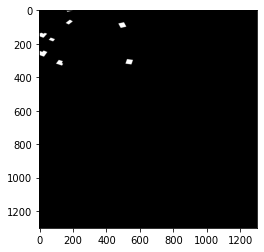

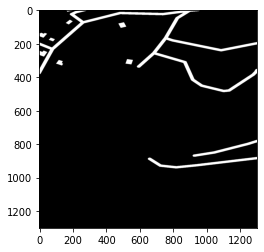

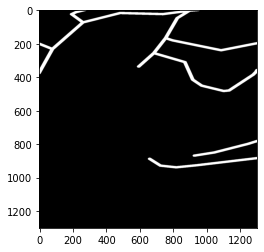

UnidentifiedImageError: cannot identify image file '/tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/roadspeed_10500500C4DD7000_0_16_67.tif'

In [165]:
# a = '/tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/flood_10500500C4DD7000_0_16_67.tif'
id = '10500500C4DD7000_0_16_67.tif'
root = '/tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/'
show_im(os.path.join(root, 'building_' + id))
show_im(os.path.join(root, 'flood_' + id))
show_im(os.path.join(root, 'road_' + id))
show_im(os.path.join(root, 'roadspeed_' + id))

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1300, 'height': 1300, 'count': 8, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.74298035050102e-06, 0.0, 6.9177180913920315,
       0.0, -3.74298035050102e-06, 50.492152019242994), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


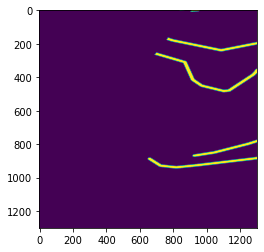

In [174]:
# img = Image.open('/tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/roadspeed_10500500C4DD7000_0_16_67.tif')

import rasterio
import matplotlib.pyplot as plt

# Open the image
with rasterio.open('/tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/roadspeed_10500500C4DD7000_0_16_67.tif') as src:
    print(src.profile)
    # img = src.read(2)  # read the first band; adjust as needed

# Display the image
plt.imshow(img)
plt.show()
